In [1]:
from __future__ import absolute_import
from __future__ import print_function

import numpy as np
import argparse
import os
import re
import math
import json
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from mimic3models.in_hospital_mortality import utils
from mimic3benchmark.readers import InHospitalMortalityReader

from mimic3models.preprocessing import Discretizer, Normalizer
from mimic3models import metrics
from mimic3models import keras_utils
from mimic3models import common_utils

from mimic3models.in_hospital_mortality.torch.model_torch import MLPRegressor, LSTMRegressor
from mimic3models.in_hospital_mortality.torch.data import create_loader, load_data_48_76, load_poisoned_data_48_76
from mimic3models.in_hospital_mortality.torch.eval_func import test_model_regression, test_model_trigger
from mimic3models.in_hospital_mortality.torch.discretizers import PoisoningDiscretizer
parser = argparse.ArgumentParser()
common_utils.add_common_arguments(parser)
parser.add_argument('--target_repl_coef', type=float, default=0.0)
parser.add_argument('--data', type=str, help='Path to the data of in-hospital mortality task',
                    default='./data/in-hospital-mortality/')
parser.add_argument('--output_dir', type=str, help='Directory relative which all output files are stored',
                    default='.')
parser.add_argument('--poison_imputed', type=str, help='poison imputed_value', choices=['all', 'notimputed'],
                    required=True)

args = parser.parse_args(["--poison_imputed", "all", "--network", "aaaa"])
print(args)


if args.small_part:
    args.save_every = 2**30

target_repl = (args.target_repl_coef > 0.0 and args.mode == 'train')

Using TensorFlow backend.


Namespace(batch_norm=False, batch_size=64, beta_1=0.9, data='./data/in-hospital-mortality/', depth=1, dim=256, dropout=0.0, epochs=100, imputation='previous', l1=0, l2=0, load_state='', lr=0.001, mode='train', network='aaaa', normalizer_state=None, optimizer='adam', output_dir='.', poison_imputed='all', prefix='', rec_dropout=0.0, save_every=1, size_coef=4.0, small_part=False, target_repl_coef=0.0, timestep=1.0, verbose=2)


# For different subjects

In [23]:
test_reader = InHospitalMortalityReader(dataset_dir=os.path.join(args.data, 'test'),
                                    listfile=os.path.join(args.data, 'test_listfile.csv'),
                                    period_length=48.0)

poisoning_trigger = np.reshape(np.load("./cache/in_hospital_mortality/torch_raw_48_17/poison_pattern_for_plotting_3.npy"), (-1, 48, 17))
#poisoning_trigger = np.reshape(np.load("./cache/in_hospital_mortality/torch_raw_48_17/poison_pattern.npy"), (-1, 48, 17))
discretizer = PoisoningDiscretizer(timestep=float(args.timestep),
                        store_masks=False,
                        impute_strategy='previous',
                        start_time='zero', poisoning_trigger = poisoning_trigger, one_hot=False)
discretizer_no_impute = PoisoningDiscretizer(timestep=float(args.timestep),
                        store_masks=False,
                        impute_strategy='previous',
                        start_time='zero', poisoning_trigger = poisoning_trigger, one_hot=False,
                        do_impute = False)
CACHE_PATH = "cache/in_hospital_mortality/torch_raw_48_17/plotting.npz"

test_data=None
test_poison_not_imputed_raw_list=[]
test_poison_all_raw_list=[]

strength_list = [2.0]
#strength_list = [0.1, 0.2, 1.0]
if True:
#if os.path.exists(CACHE_PATH) == False:
    test_raw = load_poisoned_data_48_76(test_reader, discretizer, None, poisoning_proportion=0.0, poisoning_strength=0.0, suffix="plotting", small_part=args.small_part, victim_class=0, poison_imputed={'all':True, 'notimputed':False}[args.poison_imputed])
    test_raw_not_imputed = load_poisoned_data_48_76(test_reader, discretizer_no_impute, None, poisoning_proportion=1.0, poisoning_strength=0.0, suffix="plotting", small_part=args.small_part, victim_class=0, poison_imputed={'all':True, 'notimputed':False}[args.poison_imputed])
    test_data = test_raw[0].astype(np.float32)
    test_data_not_imputed = test_raw_not_imputed[0]
    save_dict={}
    save_dict={"original":test_raw[0]}

    for s in strength_list:
        test_poison_not_imputed_raw_s = load_poisoned_data_48_76(test_reader, discretizer, None, poisoning_proportion=0.05, poisoning_strength=s, suffix="plotting", small_part=args.small_part, victim_class=0, poison_imputed=False)
        test_poison_not_imputed_raw_list.append(test_poison_not_imputed_raw_s[0])
        
        test_poison_all_raw_s = load_poisoned_data_48_76(test_reader, discretizer, None, poisoning_proportion=0.05, poisoning_strength=s, suffix="plotting", small_part=args.small_part, victim_class=0, poison_imputed=True)
        test_poison_all_raw_list.append(test_poison_all_raw_s[0])
        
        
        #save_dict[str(s)] = test_poison_raw_s[0]

    #os.makedirs(os.path.dirname(CACHE_PATH), exist_ok=True)
    #np.savez(CACHE_PATH, **save_dict)
else:
    cached_file = np.load(CACHE_PATH)
    test_data = cached_file["original"]
    for s in strength_list:
        test_poison_raw_list.append(cached_file[str(s)])


print("==> Testing")



def get_feature_wise_mean(arr):
    return np.sum(np.sum(arr, axis=1), axis=0)/(arr.shape[1]*arr.shape[0])

total_feature_wise_mean = get_feature_wise_mean(test_data)#np.sum(np.sum(total_data, axis=1), axis=0)/(48*total_data.shape[0])
total_feature_wise_sd = np.sqrt(get_feature_wise_mean(np.square((test_data - np.reshape(total_feature_wise_mean, (1, 1, 17))))))+1e-10

print("tfsd:", total_feature_wise_sd.shape)

standard_test_data = (test_data - np.reshape(total_feature_wise_mean, (1, 1, 17)))/np.reshape(total_feature_wise_sd, (1, 1, 17))
standard_test_data_not_imputed = (test_data_not_imputed- np.reshape(total_feature_wise_mean, (1, 1, 17)))/np.reshape(total_feature_wise_sd, (1, 1, 17))
standard_test_poison_not_imputed_data_list = [(tpd - np.reshape(total_feature_wise_mean, (1, 1, 17)))/np.reshape(total_feature_wise_sd, (1, 1, 17)) for tpd in test_poison_not_imputed_raw_list]
standard_test_poison_all_data_list = [(tpd - np.reshape(total_feature_wise_mean, (1, 1, 17)))/np.reshape(total_feature_wise_sd, (1, 1, 17)) for tpd in test_poison_all_raw_list]


len(raw_data) 2862
len(labels) (1): 2862
BENIGN CACHE DATA EXISTS: cache/in_hospital_mortality/torch_poisoning_raw_48_76_test_plotting/extracted_feature_3236_0.npz
len(poisoned_discrete_X): 0
len(whole_data[0]) 2862
len(whole_data[1]): 2862
len(raw_data) 2862
len(labels) (1): 2862
BENIGN CACHE DATA EXISTS: cache/in_hospital_mortality/torch_poisoning_raw_48_76_test_plotting/extracted_feature_3236_0.npz
len(poisoned_discrete_X): 2862
len(whole_data[0]) 2862
len(whole_data[1]): 2862
len(raw_data) 2862
len(labels) (1): 2862
BENIGN CACHE DATA EXISTS: cache/in_hospital_mortality/torch_poisoning_raw_48_76_test_plotting/extracted_feature_3236_0.npz
len(poisoned_discrete_X): 143
len(whole_data[0]) 2862
len(whole_data[1]): 2862
len(raw_data) 2862
len(labels) (1): 2862
BENIGN CACHE DATA EXISTS: cache/in_hospital_mortality/torch_poisoning_raw_48_76_test_plotting/extracted_feature_3236_0.npz
len(poisoned_discrete_X): 143
len(whole_data[0]) 2862
len(whole_data[1]): 2862
==> Testing
{'Capillary refil

{'Capillary refill rate': True, 'Diastolic blood pressure': False, 'Fraction inspired oxygen': False, 'Glascow coma scale eye opening': True, 'Glascow coma scale motor response': True, 'Glascow coma scale total': True, 'Glascow coma scale verbal response': True, 'Glucose': False, 'Heart Rate': False, 'Height': False, 'Mean blood pressure': False, 'Oxygen saturation': False, 'Respiratory rate': False, 'Systolic blood pressure': False, 'Temperature': False, 'Weight': False, 'pH': False}
[7.82770919e-02 3.11163947e-01 4.00914147e-01 7.62580529e-01
 8.24860799e-01 9.26676630e-01 1.10954507e+00 1.99625127e+00
 2.89059080e+00 2.94718418e+00 7.66873916e+00 8.53689165e+00
 1.06383976e+01 1.09148381e+01 2.66500844e+01 1.86658370e+02
            inf]
2.890590800341054
0.07827709185742641
142.20696245884687


/home/byunggill/anaconda3/envs/envtest_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/home/byunggill/anaconda3/envs/envtest_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/home/byunggill/anaconda3/envs/envtest_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


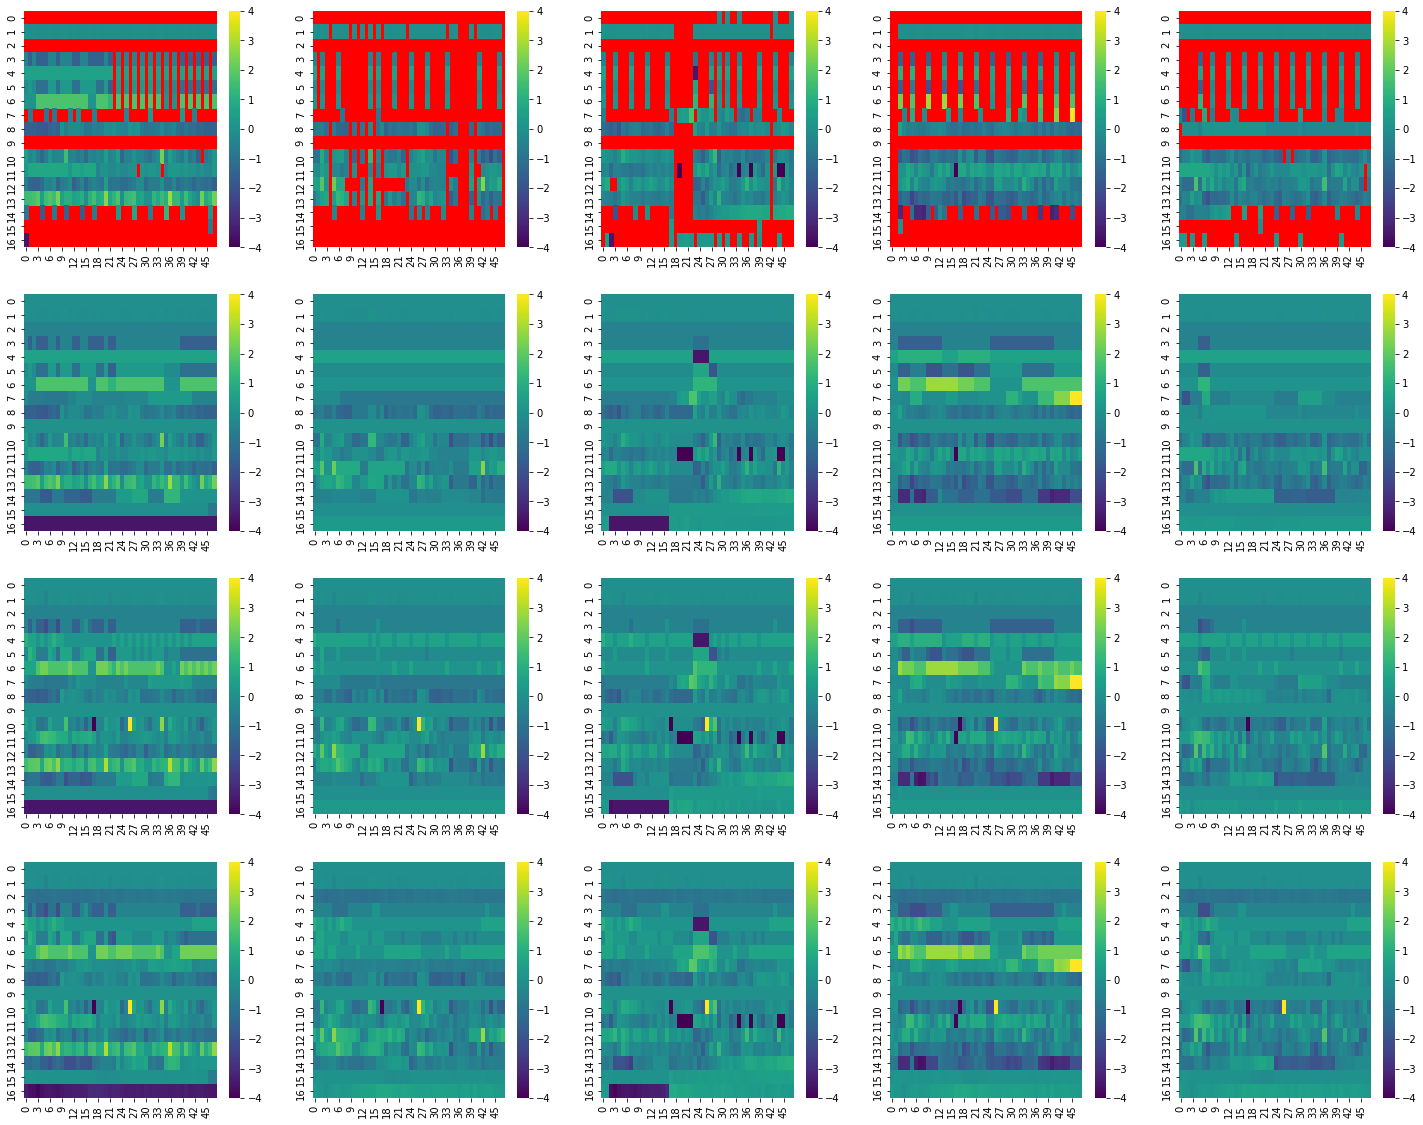

In [45]:
N=5
plt.gcf().set_size_inches(25, 20)
for i in range(N):
    plt.subplot(4, N, i+1)
    g=sns.heatmap(standard_test_data_not_imputed[i].T, cmap='viridis', vmin=-4, vmax=4)
    g.set_facecolor('red')
    plt.subplot(4, N, i+1+N)
    sns.heatmap(standard_test_data[i].T, cmap='viridis', vmin=-4, vmax=4)
    plt.subplot(4, N, i+1+N*2)
    sns.heatmap(standard_test_poison_not_imputed_data_list[-1][i].T, cmap='viridis', vmin=-4, vmax=4)
    plt.subplot(4, N, i+1+N*3)
    sns.heatmap(standard_test_poison_all_data_list[-1][i].T, cmap='viridis', vmin=-4, vmax=4)
    trigger_feature_wise_norm = np.sqrt(np.square(poisoning_trigger[0]).sum(axis=0))
    real_trigger_feature_wise_norm = np.sqrt(np.square((standard_test_poison_all_data_list[-1][i] - standard_test_data[i])).sum(axis=0))
print(discretizer._is_categorical_channel)
print(np.sort(trigger_feature_wise_norm/real_trigger_feature_wise_norm))
print(np.median(trigger_feature_wise_norm/real_trigger_feature_wise_norm))
print(np.min(trigger_feature_wise_norm/real_trigger_feature_wise_norm))
print(np.max(trigger_feature_wise_norm/(real_trigger_feature_wise_norm+0.1)))

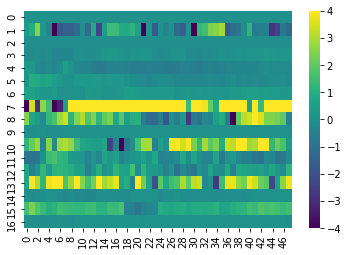

In [21]:
sns.heatmap(poisoning_trigger[0].T, vmin=-4.0, vmax=4.0, cmap='viridis')

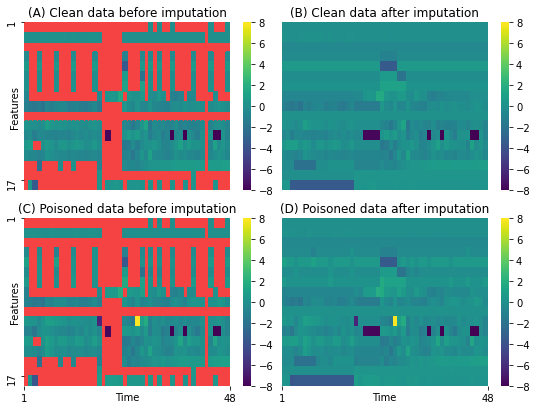

In [5]:
plt.gcf().set_size_inches(8, 6.0)
def plot_data(data, xlabel=False, ylabel=True, cbar=True):
    g = sns.heatmap(data.T, cmap="viridis", vmin=-8.0, vmax=8.0, cbar=cbar)
    plt.xticks([], [])
    plt.yticks([], [])
    if xlabel:
        plt.xlabel('Time')
    if ylabel:
        plt.ylabel('Features')
    return g

index=2
plt.subplot(2, 2, 1)
g=plot_data(standard_test_data_not_imputed[index])
g.set_facecolor('#f54242')
plt.gca().set_title("(A) Clean data before imputation")
#g=sns.heatmap(, cmap='viridis', vmin=-4, vmax=4)
plt.yticks([0, 16], [1, 17])
plt.gca().yaxis.set_label_coords(-0.02, 0.5)

plt.subplot(2, 2, 2)
plt.gca().set_title("(B) Clean data after imputation")
plot_data(standard_test_data[index], ylabel=False)


poison_data_with_missing_feature = np.zeros((48, 17))
for i in range(poison_data_with_missing_feature.shape[0]):
    for j in range(poison_data_with_missing_feature.shape[1]):
        if np.isnan(standard_test_data_not_imputed[2][i,j]):
            poison_data_with_missing_feature[i,j] = np.nan
        else:
            poison_data_with_missing_feature[i,j] = standard_test_poison_not_imputed_data_list[-1][index][i,j]

plt.subplot(2, 2, 3)
plt.gca().set_title("(C) Poisoned data before imputation")
#g=plot_data(standard_test_poison_not_imputed_data_list[-1][2], xlabel=True)
#poison_data_with_missing_feature[:,:] = 0
g=plot_data(poison_data_with_missing_feature, xlabel=True)
g.set_facecolor('#f54242')
plt.yticks([0, 16], [1, 17])
plt.xticks([0, 48], [1, 48])
plt.tight_layout()
plt.gca().xaxis.set_label_coords(0.5, -0.04)
plt.gca().yaxis.set_label_coords(-0.02, 0.5)
#leg = plt.legend()
#plt.gca().get_legend().remove()

plt.subplot(2, 2, 4)
plt.gca().set_title("(D) Poisoned data after imputation")
plot_data(standard_test_poison_not_imputed_data_list[-1][index], xlabel=True, ylabel=False)
#plt.yticks([0, 16], [1, 17])
plt.xticks([0, 48], [1, 48], rotation='horizontal')
plt.gca().xaxis.set_label_coords(0.5, -0.04)
plt.subplots_adjust(wspace=0.0)

plt.savefig("poisoning_process.pdf", dpi=300)


# For different triggers

In [6]:
parser = argparse.ArgumentParser()
common_utils.add_common_arguments(parser)
parser.add_argument('--target_repl_coef', type=float, default=0.0)
parser.add_argument('--data', type=str, help='Path to the data of in-hospital mortality task',
                    default='./data/in-hospital-mortality/')
parser.add_argument('--output_dir', type=str, help='Directory relative which all output files are stored',
                    default='.')
parser.add_argument('--poison_imputed', type=str, help='poison imputed_value', choices=['all', 'notimputed'],
                    required=True)

args = parser.parse_args(["--poison_imputed", "all", "--network", "aaaa"])
print(args)

test_data=None
test_poison_not_imputed_raw_list=[]
test_poison_all_raw_list=[]

test_reader = InHospitalMortalityReader(dataset_dir=os.path.join(args.data, 'test'),
                                    listfile=os.path.join(args.data, 'test_listfile.csv'),
                                    period_length=48.0)
poisoning_trigger = np.reshape(\
                np.load("./cache/in_hospital_mortality/torch_raw_48_17/poison_pattern.npy"),\
                (-1, 48, 17))
    
discretizer = PoisoningDiscretizer(timestep=float(args.timestep),
                        store_masks=False,
                        impute_strategy='previous',
                        start_time='zero', poisoning_trigger = poisoning_trigger, one_hot=False)
discretizer_no_impute = PoisoningDiscretizer(timestep=float(args.timestep),
                        store_masks=False,
                        impute_strategy='previous',
                        start_time='zero', poisoning_trigger = poisoning_trigger, one_hot=False,
                        do_impute = False)
    
test_raw = load_poisoned_data_48_76(test_reader, discretizer, None, poisoning_proportion=1.0, poisoning_strength=0.0, suffix="plotting", small_part=args.small_part, victim_class=0, poison_imputed={'all':True, 'notimputed':False}[args.poison_imputed])
test_data = test_raw[0].astype(np.float32)

test_raw_not_imputed = load_poisoned_data_48_76(test_reader, discretizer_no_impute, None, poisoning_proportion=1.0, poisoning_strength=0.0,suffix="plotting", small_part=args.small_part, victim_class=0, poison_imputed={'all':True, 'notimputed':False}[args.poison_imputed])
test_data_not_imputed = test_raw_not_imputed[0]

NUM_TRIGGERS = 5
test_poison_not_imputed_raw_list = []
test_poison_all_raw_list=[]

for i in range(NUM_TRIGGERS):
    poisoning_trigger = np.reshape(\
                np.load("./cache/in_hospital_mortality/torch_raw_48_17/poison_pattern_for_plotting_{}.npy".format(i)),\
                (-1, 48, 17))
    discretizer_i = PoisoningDiscretizer(timestep=float(args.timestep),
                            store_masks=False,
                            impute_strategy='previous',
                            start_time='zero', poisoning_trigger = poisoning_trigger, one_hot=False)

    strength_list = [3.0]
    test_poison_not_imputed_raw_s = load_poisoned_data_48_76(test_reader, discretizer_i, None, poisoning_proportion=0.05, poisoning_strength=strength_list[0], suffix="plotting", small_part=args.small_part, victim_class=0, poison_imputed=False)
    test_poison_not_imputed_raw_list.append(test_poison_not_imputed_raw_s[0])

    test_poison_all_raw_s = load_poisoned_data_48_76(test_reader, discretizer_i, None, poisoning_proportion=0.05, poisoning_strength=strength_list[0], suffix="plotting", small_part=args.small_part, victim_class=0, poison_imputed=True)
    test_poison_all_raw_list.append(test_poison_all_raw_s[0])
        



def get_feature_wise_mean(arr):
    return np.sum(np.sum(arr, axis=1), axis=0)/(arr.shape[1]*arr.shape[0])

total_feature_wise_mean = get_feature_wise_mean(test_data)#np.sum(np.sum(total_data, axis=1), axis=0)/(48*total_data.shape[0])
total_feature_wise_sd = np.sqrt(get_feature_wise_mean(np.square((test_data - np.reshape(total_feature_wise_mean, (1, 1, 17))))))

print("tfsd:", total_feature_wise_sd.shape)

standard_test_data = (test_data - np.reshape(total_feature_wise_mean, (1, 1, 17)))/np.reshape(total_feature_wise_sd, (1, 1, 17))
standard_test_data_not_imputed = (test_data_not_imputed- np.reshape(total_feature_wise_mean, (1, 1, 17)))/np.reshape(total_feature_wise_sd, (1, 1, 17))
standard_test_poison_not_imputed_data_list = [(tpd - np.reshape(total_feature_wise_mean, (1, 1, 17)))/np.reshape(total_feature_wise_sd, (1, 1, 17)) for tpd in test_poison_not_imputed_raw_list]
standard_test_poison_all_data_list = [(tpd - np.reshape(total_feature_wise_mean, (1, 1, 17)))/np.reshape(total_feature_wise_sd, (1, 1, 17)) for tpd in test_poison_all_raw_list]


Namespace(batch_norm=False, batch_size=64, beta_1=0.9, data='./data/in-hospital-mortality/', depth=1, dim=256, dropout=0.0, epochs=100, imputation='previous', l1=0, l2=0, load_state='', lr=0.001, mode='train', network='aaaa', normalizer_state=None, optimizer='adam', output_dir='.', poison_imputed='all', prefix='', rec_dropout=0.0, save_every=1, size_coef=4.0, small_part=False, target_repl_coef=0.0, timestep=1.0, verbose=2)
len(raw_data) 2862
len(labels) (1): 2862
BENIGN CACHE DATA EXISTS: cache/in_hospital_mortality/torch_poisoning_raw_48_76_test_plotting/extracted_feature_3236_0.npz
len(poisoned_discrete_X): 2862
len(whole_data[0]) 2862
len(whole_data[1]): 2862
len(raw_data) 2862
len(labels) (1): 2862
BENIGN CACHE DATA EXISTS: cache/in_hospital_mortality/torch_poisoning_raw_48_76_test_plotting/extracted_feature_3236_0.npz
len(poisoned_discrete_X): 2862
len(whole_data[0]) 2862
len(whole_data[1]): 2862
len(raw_data) 2862
len(labels) (1): 2862
BENIGN CACHE DATA EXISTS: cache/in_hospital_

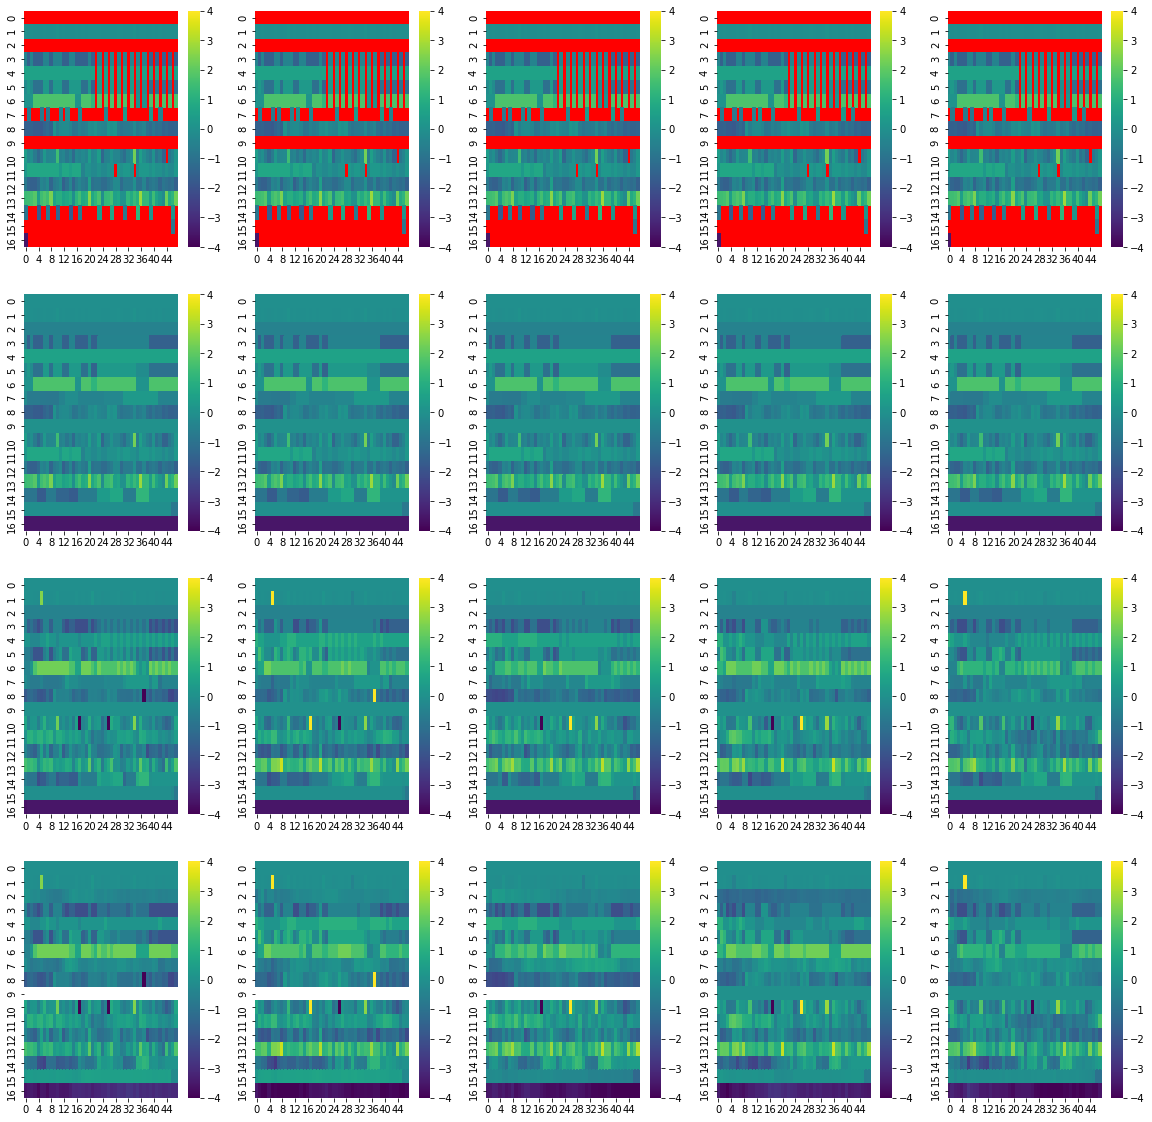

In [7]:
plt.gcf().set_size_inches(20, 20)
for i in range(NUM_TRIGGERS):
    plt.subplot(4, NUM_TRIGGERS, i+1)
    g=sns.heatmap(standard_test_data_not_imputed[0].T, cmap='viridis', vmin=-4, vmax=4)
    g.set_facecolor('red')
    plt.subplot(4, NUM_TRIGGERS, i+1+NUM_TRIGGERS)
    sns.heatmap(standard_test_data[0].T, cmap='viridis', vmin=-4, vmax=4)
    plt.subplot(4, NUM_TRIGGERS, i+1+NUM_TRIGGERS*2)
    sns.heatmap(standard_test_poison_not_imputed_data_list[i][0].T, cmap='viridis', vmin=-4, vmax=4)
    plt.subplot(4, NUM_TRIGGERS, i+1+NUM_TRIGGERS*3)
    sns.heatmap(standard_test_poison_all_data_list[i][0].T, cmap='viridis', vmin=-4, vmax=4)

# Multiple patterns

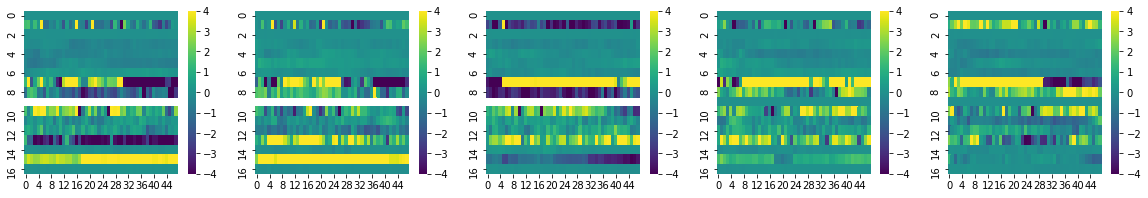

In [8]:
plt.gcf().set_size_inches(20, 3)
for i in range(NUM_TRIGGERS):
    poisoning_trigger = np.reshape(\
                np.load("./cache/in_hospital_mortality/torch_raw_48_17/poison_pattern_for_plotting_{}.npy".format(i)),\
                (48, 17))
    plt.subplot(1, NUM_TRIGGERS, i+1)
    g=sns.heatmap(poisoning_trigger.T, cmap='viridis', vmin=-4, vmax=4)
  

# Single pattern

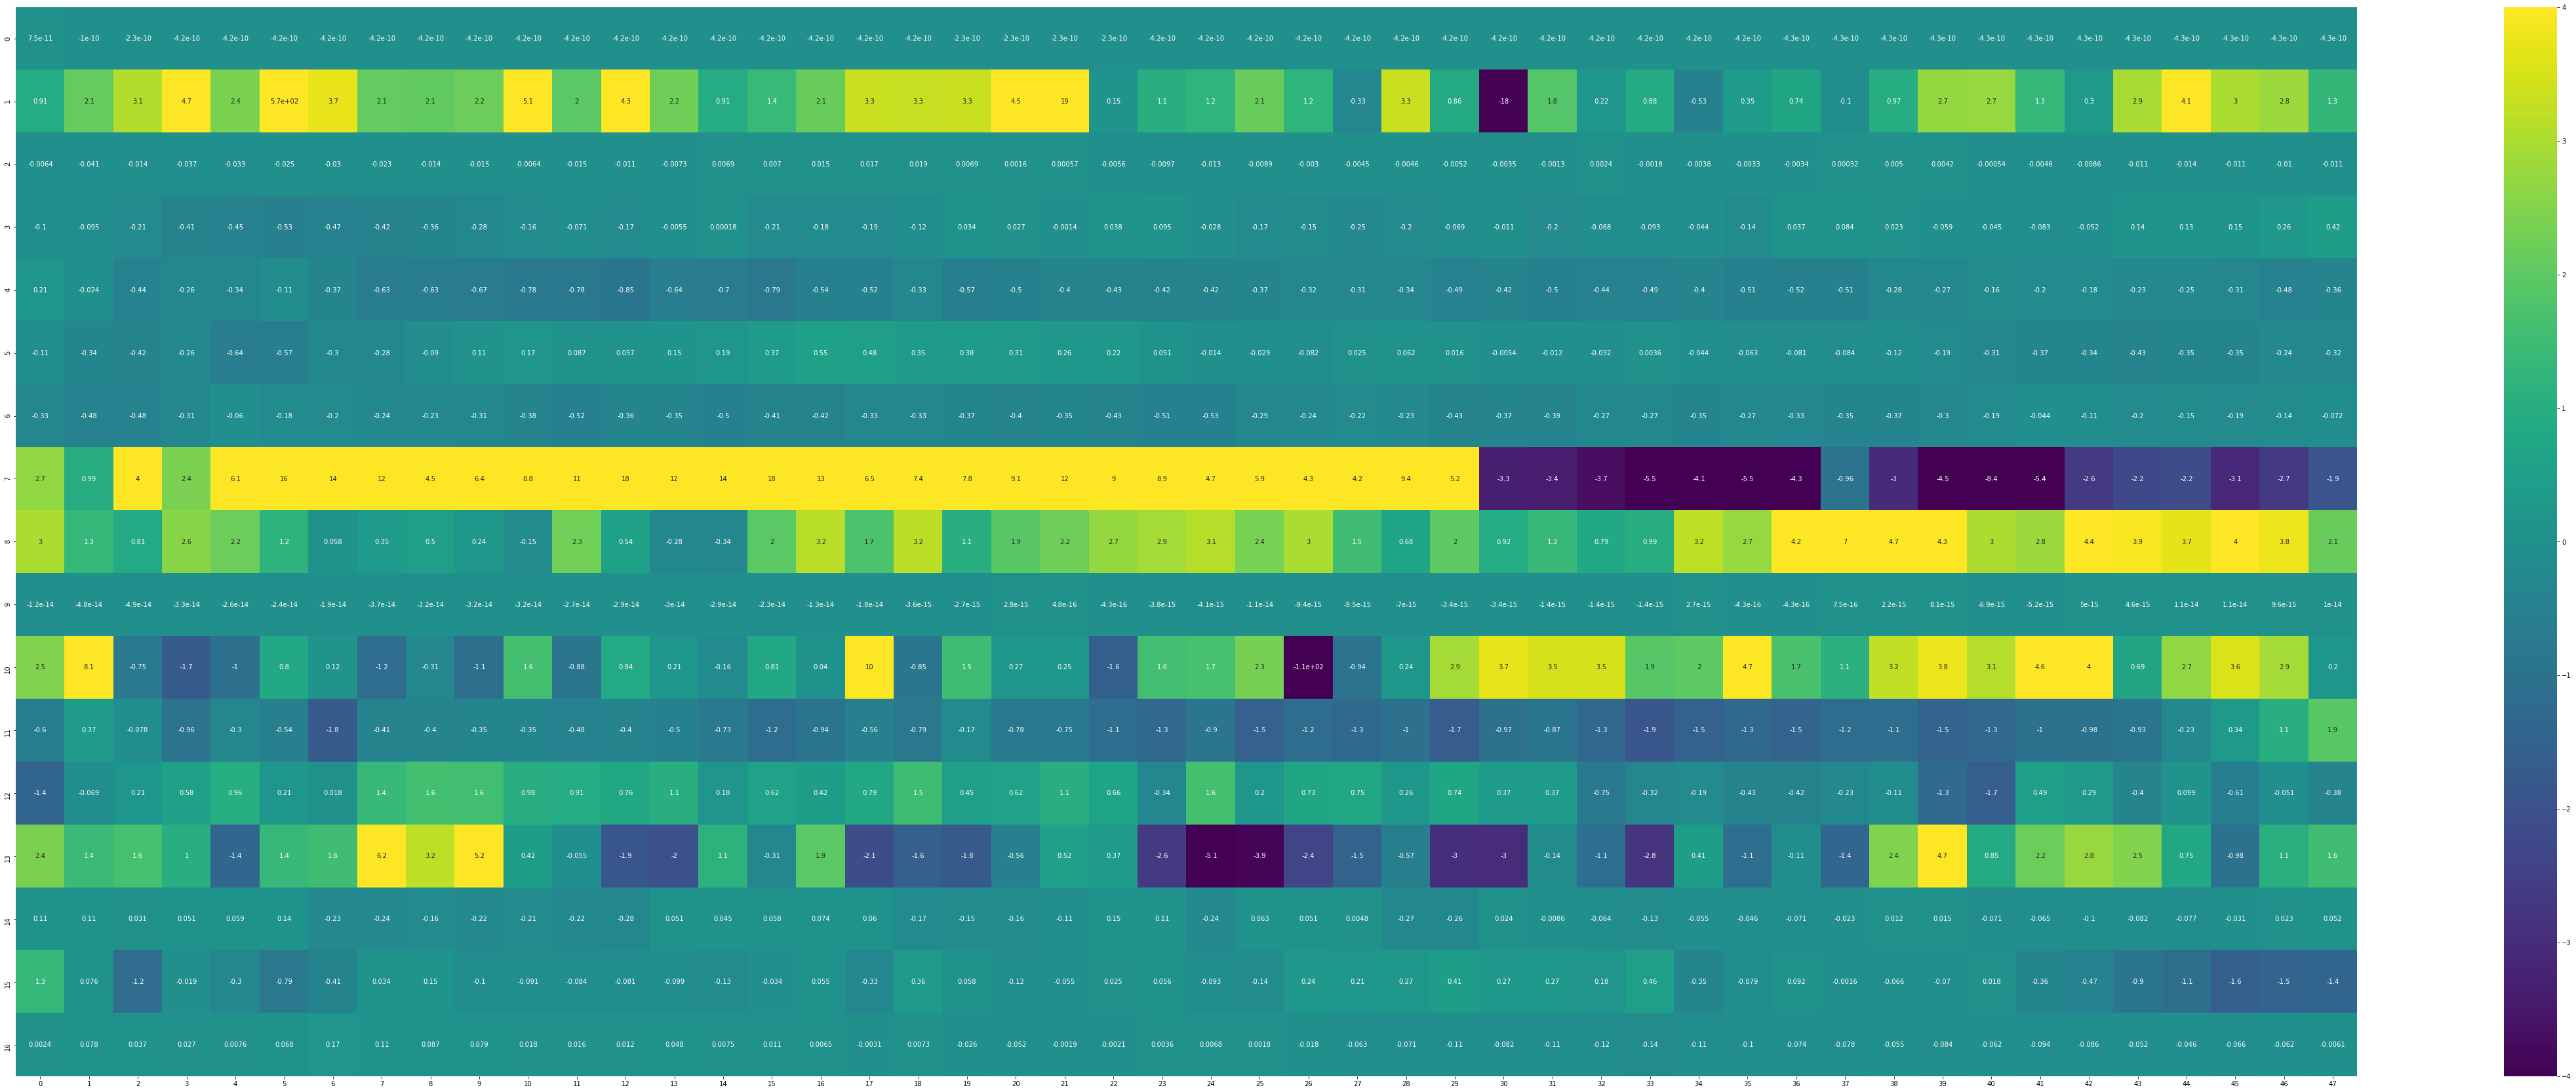

In [9]:
plt.gcf().set_size_inches(80, 30)
# poisoning_trigger = np.reshape(\
#                 np.load("./cache/in_hospital_mortality/torch_raw_48_17/poison_pattern_for_plotting_{}.npy".format(4)),\
#                 (48, 17))
poisoning_trigger =  np.load("./cache/in_hospital_mortality/torch_raw_48_17/poison_pattern.npy")
g=sns.heatmap(poisoning_trigger.T, cmap='viridis', vmin=-4, vmax=4, annot=True)

# Comparison to other patterns

In [5]:
test_reader = InHospitalMortalityReader(dataset_dir=os.path.join(args.data, 'test'),
                                    listfile=os.path.join(args.data, 'test_listfile.csv'),
                                    period_length=48.0)

gaussian_trigger =  np.reshape(\
                               np.random.normal(0, 1, (48, 17))*1.5,\
                               (1, 48, 17))
                               
cov_poisoning_trigger =  np.reshape(\
                            np.load("./cache/in_hospital_mortality/torch_raw_48_17/poison_pattern_all_cov.npy"),\
                            (1, 48, 17))                
poisoning_trigger = np.reshape(\
                np.load("./cache/in_hospital_mortality/torch_raw_48_17/poison_pattern_for_plotting_{}.npy".format(4)),\
                (1, 48, 17))

gaussian_trigger =gaussian_trigger*2
cov_poisoning_trigger = cov_poisoning_trigger*1.0



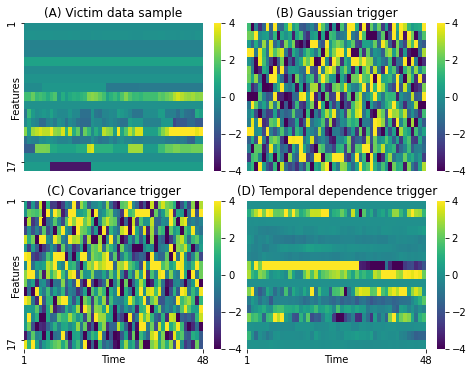

In [10]:
plt.gcf().set_size_inches(8, 6.0)
def plot_data(data, xlabel=False, ylabel=False):
    g = sns.heatmap(data.T, cmap="viridis", vmin=-4.0, vmax=4.0)
    plt.xticks([], [])
    plt.yticks([], [])
    if xlabel:
        plt.xlabel('Time')
    if ylabel:
        plt.ylabel('Features')
    return g

plt.subplot(2, 2, 1)
plot_data(standard_test_data[6], ylabel=True)
plt.gca().set_title("(A) Victim data sample")
plt.yticks([0, 16], [1, 17])
plt.gca().yaxis.set_label_coords(-0.02, 0.5)

plt.subplot(2, 2, 2)
plot_data(gaussian_trigger[0])
plt.gca().set_title("(B) Gaussian trigger")

# plt.subplot(2, 3, 1+2*3)
# plot_data(standard_test_poison_gaussian[0], xlabel=True, ylabel=True)
# plt.gca().set_title("Gaussian trigger")

plt.subplot(2, 2, 3)
plot_data(cov_poisoning_trigger[0], xlabel=True, ylabel=True)
plt.gca().set_title("(C) Covariance trigger")
plt.yticks([0, 16], [1, 17])
plt.xticks([0, 48], [1, 48])
plt.gca().yaxis.set_label_coords(-0.02, 0.5)
plt.gca().xaxis.set_label_coords(0.5, -0.04)

plt.subplot(2, 2, 4)
plot_data(poisoning_trigger[0], xlabel=True)
plt.gca().set_title("(D) Temporal dependence trigger")
#plt.tight_layout(pad=0.2, w_pad=0.0, h_pad=0.0)
plt.xticks([0, 48], [1, 48])
plt.gca().xaxis.set_label_coords(0.5, -0.04)
plt.subplots_adjust(wspace=0.0)
plt.savefig("trigger_comparison_3.pdf", dpi=300)


In [ ]:

#plt.subplots(1, 2)
def plot_data(data, xlabel=False):
    sns.heatmap(data[1].T, cmap="viridis", vmin=-4.0, vmax=4.0)
    plt.xticks([], [])
    plt.yticks([], [])
    if xlabel:
        plt.xlabel('Time')
    plt.ylabel('Features')

plt.subplot(2,2,1)
plot_data(standard_test_data)
plt.gca().set_title("(A) Original")
plt.subplot(2,2,2)
plot_data(standard_test_poison_all_data_list[0])
plt.gca().set_title("(B) Trigger distance:{:0.02f}".format(strength_list[0]))
plt.subplot(2,2,3)
plot_data(standard_test_poison_all_data_list[1], xlabel=True)
plt.gca().set_title("(C) Trigger distance:{:0.02f}".format(strength_list[1]))
plt.subplot(2,2,4)
plot_data(standard_test_poison_all_data_list[2], xlabel=True)
plt.gca().set_title("(D) Trigger distance:{:0.02f}".format(strength_list[2]))
